In [50]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf

In [2]:
# TODO: create second model to classify points before using regressor model

training = pd.read_csv('training.csv')
testing = pd.read_csv('test.csv')
# input -1 for missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)

# This code was removing column names, my changes rename the columns so they keep original values now
# Convert back to dataframe and replace the missing values
training = pd.DataFrame(imputer.fit_transform(training), columns=training.columns)
# training = pd.DataFrame(training, columns=training.columns)
y_training = training.loc[:, :"mouth_center_bottom_lip_y"]


# Get the last feature column
lastFeature = training.iloc[:, -1]

# Split the last feature by spaces
splitFeatures = lastFeature.str.split(' ', expand=True)

# Drop the original last feature and concatenate the new split features
training = pd.concat([training.drop(training.columns[-1], axis=1), splitFeatures], axis=1)


# I drop the first columns here so they aren't mislabeled, and this way we can just make this the X_train
training.drop(training.columns[range(0, 30)], axis=1, inplace=True)


# This was renaming all target columns to pixel_i as well--code added before getting the last feature column fixes this
# Rename the columns to pixel_i
training.columns = [f'pixel_{i}' for i in range(training.shape[1])]


# Same for testing
testImg = testing.iloc[:, -1]
splitTest = testImg.str.split(' ', expand=True)
testing = pd.concat([testing.drop(testing.columns[-1], axis=1), splitTest], axis=1)

# there was an extra column that was just the index
testing.drop(columns=testing.columns[[0]], inplace=True)

# Rename the columns to pixel_i
testing.columns = ['ImageId'] + [f'pixel_{i}' for i in range(1, testing.shape[1])]

In [3]:
# Need to split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(training, y_training, train_size=0.8, test_size=0.2, random_state=10)

In [4]:
# Reshape dataframe into numpy array so I can reshape it again
X_train = X_train.to_numpy(dtype=np.float32)

# Reshape image data so the model can process it as a Tensor
X_train = X_train.reshape(5639, 96, 96, 1)
X_train = X_train / 255.0

# Reshape y_train into a numpy array as well
y_train = np.array(y_train, dtype=np.float32)

# Reshape test data
X_test = X_test.to_numpy(dtype=np.float32)
X_test = X_test.reshape(1410, 96, 96, 1)
X_test = X_test / 255.0

y_test = np.array(y_test, dtype=np.float32)

In [57]:
final_test_data = testing.to_numpy(dtype=np.float32)
final_test_data = final_test_data.reshape(1783, 96, 96, 1)
final_test_data /= 255.0

# creates a submission for a model that outputs a 60 term vector (weights not enough answers towards private score)
def create_submission(model, name):
    predictions = model.predict(final_test_data)

    predictions_df = pd.DataFrame(columns=['Location'])
    predictions_df.index.name = 'RowId'
    print(f"length of predictions: {len(predictions)} (Expected 27,124)")
    print(predictions_df)
    i = 1
    locations = []
    for image in range(len(predictions)):
        # j = 0
        for j in range(30):
            if predictions[image][j*2+1] >= 0 and predictions[image][j*2+1] <= 96 and i < 27125 and predictions[image][j*2] > 0.5:
                locations.append(predictions[image][j*2+1])
                i += 1
                # j += 2
    while i < 27125:
        locations.insert(0, 0)
        i += 1
        
    for item in range(27124):
        predictions_df.loc[item+1] = float(locations[item])
    print(predictions_df)
    predictions_df.to_csv(name)

# creates a submission for a model that outputs two 30 term vectors
def create_submission_2_outputs(model, name):
    predictions = model.predict(final_test_data)
    predictions_df = pd.DataFrame(columns=['Location'])
    predictions_df.index.name = 'RowId'
    print(f"length of predictions: {len(predictions)} (Expected 27,124)")
    print(predictions_df)
    i = 1
    locations = []
    for image in range(len(predictions)):
        # j = 0
        for j in range(30):
            if predictions[image][j*2+1] >= 0 and predictions[image][j*2+1] <= 96 and i < 27125 and predictions[image][j*2] > 0.5:
                locations.append(predictions[image][j*2+1])
                i += 1
                # j += 2
    while i < 27125:
        locations.insert(0, 0)
        i += 1
        
    for item in range(27124):
        predictions_df.loc[item+1] = float(locations[item])
    print(predictions_df)
    predictions_df.to_csv(name)

In [44]:
def transform_array_2_outputs(array):
    new_array = []
    for i in range(len(array)):
        new_array.append([])
        for x in range(30):
            if array[i][x] == -1:
                new_array[i].append(0)
            else:
                new_array[i].append(1)
    return np.array(new_array)



def transform_array(array):
    new_array = []
    for i in range(len(array)):
        new_array.append([])
        for x in range(30):
            if array[i][x] == -1:
                new_array[i].append(0)
            else:
                new_array[i].append(1)
            new_array[i].append(array[i][x])
    return np.array(new_array)

new_y_train = transform_array(y_train)


In [19]:
# training some basic convolutional models based off of our homework
# this has to be a regression model (given that target outputs are floats) so it needs to be a little different

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(26, (3,3), activation='relu', input_shape=(96, 96, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(60)
])
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, new_y_train, epochs=10, batch_size=32)

Epoch 1/10


/home/mike/anaconda3/envs/CS5640/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 653.7403 - mean_squared_error: 653.7403
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 461.0990 - mean_squared_error: 461.0990
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 257.4411 - mean_squared_error: 257.4411
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 110.8911 - mean_squared_error: 110.8911
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 58.4275 - mean_squared_error: 58.4275
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 38.9331 - mean_squared_error: 38.9331
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 34.8157 - mean_squared_error: 34.8157
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 27.4384 - mean_squared_error: 27.4384
Epoch 9/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 26.4933 - mean_squared_error: 26.4933
Epoch 10/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 24.6489 - mean_squared_error: 24.6489


In [ ]:
input_layer = tf.keras.Input(shape=(96, 96, 1))
x = tf.keras.layers.Conv2D(26, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

# Two separate output branches
output_hardmax = tf.keras.layers.Dense(30, activation='sigmoid', name='sig_output')(x)
output_mse = tf.keras.layers.Dense(30, name='mse_output')(x)

# Combine into a single model
model = tf.keras.Model(inputs=input_layer, outputs=[output_hardmax, output_mse])

# Compile the model with different loss functions and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        'sig_output': 'categorical_crossentropy',  # Accuracy measured loss
        'mse_output': 'mean_squared_error',           # Regression loss
    },
    metrics={
        'sig_output': ['accuracy'],
        'mse_output': ['mean_squared_error'],
    }
)

model.fit(X_train, {'sig_output': transform_array_2_outputs(y_train), 'mse_output': y_train}, epochs=10, batch_size=32)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 1468.3622 - mse_output_loss: 115.6937 - mse_output_mean_squared_error: 1380.6597 - sig_output_accuracy: 0.0505 - sig_output_loss: 1352.6504
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 1469.8048 - mse_output_loss: 122.5384 - mse_output_mean_squared_error: 1380.9604 - sig_output_accuracy: 0.0339 - sig_output_loss: 1347.2643
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 1447.4858 - mse_output_loss: 121.3722 - mse_output_mean_squared_error: 1361.4965 - sig_output_accuracy: 0.0719 - sig_output_loss: 1326.1100
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 1431.8372 - mse_output_loss: 119.0230 - mse_output_mean_squared_error: 1348.6025 - sig_output_accuracy: 0.1311 - sig_output_loss: 1312.7837
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 1452.8328 - mse_output_loss: 119.8813 - mse_output_mean_squared_error: 1367.4558 - sig_output_accuracy: 0.1178 - sig_output_loss: 1332.

In [59]:
predictions = model.predict(X_test)
print(len(predictions[1]))

mse = mean_squared_error(y_test, predictions[1])
print(f'Mean Squared Error (MSE): {mse}')
# create_submission_2_outputs(model, "submission_combined1.csv")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1410
Mean Squared Error (MSE): 1385.816650390625


In [32]:
# Takes about 13 minutes to train

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(60)
])

model2.compile(optimizer='adam', loss='mean_squared_error')

model2.fit(X_train, new_y_train, epochs=30, batch_size=24, validation_split=0.2)

Epoch 1/30


/home/mike/anaconda3/envs/CS5640/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 585.9402 - val_loss: 331.0476
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 135.2158 - val_loss: 257.7426
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 70.8095 - val_loss: 130.8805
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 54.8429 - val_loss: 83.7438
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 43.1208 - val_loss: 135.9842
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 32.9995 - val_loss: 98.6446
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 30.2125 - val_loss: 79.3551
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 25.5395 - val_loss: 70.9019
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 22.6045 - val_loss: 66.7539
Epoch 10/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 16.7510 - val_loss: 63.4268
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 15.8383 - val_loss: 60.6868
Epoch 12/30
188/188 ━━━

In [43]:
predictions = model2.predict(X_test)

mse2 = mean_squared_error(transform_array(y_test), predictions)
print(f'Mean Squared Error (MSE): {mse}')
create_submission(model2, "submission_combined2.csv")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Squared Error (MSE): 89.74988263995895
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
length of predictions: 1783 (Expected 27,124)
Empty DataFrame
Columns: [Location]
Index: []
        Location
RowId           
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
...          ...
27120  38.928635
27121  47.622597
27122  63.087498
27123  46.326077
27124  73.843384

[27124 rows x 1 columns]


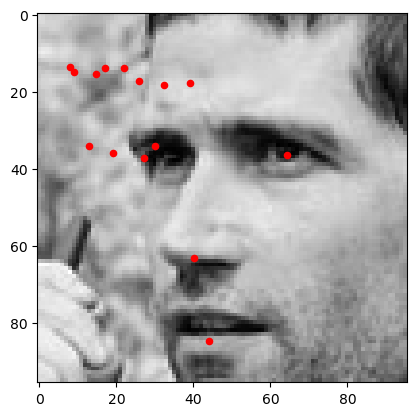

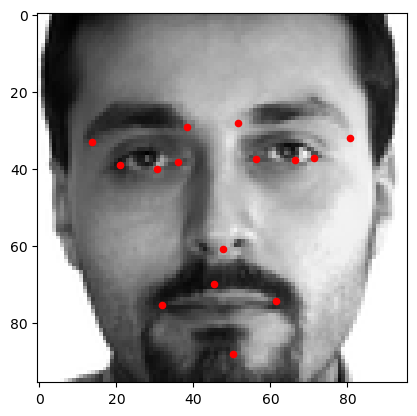

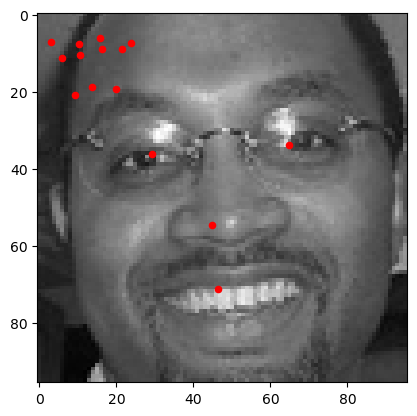

In [10]:
import matplotlib.pyplot as plt

def showPrediction(image, keypoints): # Shows the image with the predicted keypoints
    plt.imshow(image, cmap='gray')
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='red', s=20)
    plt.show()


for idx in range(20, 23):
    showPrediction(X_test[idx], y_pred[idx])